In [1]:
import numpy as np
import pandas as pd

Thanks to Nicholas Jhana's example: https://github.com/nicholasjhana/short-term-energy-demand-forecasting

# Motivation: 

### In the paper "Tackling Climate Change with Machine Learning", forecasting is identified as one of the highest impact research areas in contributing to more renewable energy in the grid.

### Energy demand forecasting is highly relevant to an effiecnt electrical grid. Improved forecasting is beneficial to deployment of renewable energy, planning for high/low load days, and reducing wastage from polluting reserve standby generation (typically inefficent gas or coal fired powerplants).

# Problem:

## What forecasting model and supervised learning problem formulation gives the lowest Mean Absolute Error (MAE) given constrained computation power?

## Models Used:

1. SARIMA
2. Prophet
3. Long-Short Term Memory Neural Network

## Analysis Process/Core Tasks:

1. Data Preprocessing/Cleaning
2. Exploratory Data Analysis (EDA)
3. Statistical Modeling
4. Machine Learning (ML)

# Data Processing
## 3 Types of Data: Energy, Weather, Holiday

Cleaning energy data, weather data and generating holiday data.

In [40]:
def process_energy_data(path='data/raw_data/energy_data/', files=['Total Load - Day Ahead _ Actual_2016.csv', 'Total Load - Day Ahead _ Actual_2017.csv', 'Total Load - Day Ahead _ Actual_2018.csv']):
    """
    Input the path and a list of file nmaes for the annual data as exported from ENTOSE. 

    Output a single dataframe with energy load data combined and cleaned.

    """

    #try to load in list of the datasets
#     try: 
#         data_sets = [pd.read_csv(path+file) for file in files]
#     except:
#         print('Error loading files')
    
    path='data/raw_data/energy_data/'
    files=['Total Load - Day Ahead _ Actual_2016.csv', 'Total Load - Day Ahead _ Actual_2017.csv', 'Total Load - Day Ahead _ Actual_2018.csv']
    data_sets = [pd.read_csv(path+file) for file in files]

    #create list of keys for the dictionary of dataframes. one per year.
    years = range(len(files))

    #create a dictionary of formatted pandas dataframes where key is each year
    format_sets = {year: format_data(data_set) for year,data_set in zip(years, data_sets)}

    #combine into one single dataframe
    data = combine_annual_data(format_sets)

    #linearly interpolate nan values
    data = interpolate_nans(data)

    #test for rows that are duplicated and keep first instance
    data = remove_duplicated_rows(data)

    return data

In [23]:
def format_data(data):
    '''
    Input: A dataframe of Day Ahead Total Load, and Actual Load obtained from csv data obtained from the entsoe Transparency Platform.
    
    Descrption:
    Input is a 3 column dataframe consisting of text time stamps with hourly frequency. 
    - Function formats the string in order to be formatted into a datetime.
    - Appends a datetime index and drops the time strings
    
    Output: A 2 column dataframe with a DatetimeIndex
    
    '''
    
    #set column names to something simple
    data.columns = ['time', 'day_forecast',
       'actual_load']

    #set the time to the first element in the time string. 
    #So 01.01.2018 00:00 - 01.01.2018 01:00 becomes 01.01.2018 00:00
    data['time'] = data['time'].str.split('-').apply(lambda x: x[0]).str.strip()
     
    #set the time strings to datetime obejects and set index as date time
    datetimes = pd.to_datetime(data['time'], format='%d-%m-%Y %H%M', errors='ignore')
    data_ = data.set_index(pd.DatetimeIndex(datetimes))
    
    #remove extra time column with original string objects
    data_time = data_[['day_forecast', 'actual_load']]
    
    return data_time

In [24]:
def combine_annual_data(dictionary):
    """
    Input: a dictionary of dataframes.
    
    Output: a single dataframe
    """
    
    all_data_list = []
    
    for key in dictionary.keys():
        all_data_list.append(dictionary[key])
        
    data_all_years = pd.concat(all_data_list)
    
    return data_all_years

In [25]:
# ### Clean NANs
# 
# This data will be used for predicting day ahead energy demand. In dealing with nan values it is important not to change the structure of the data. 
# 
# Two ways this can occur:
#    1. dropping values changes number of observations in a day. number of daily observations per day needs to line up with the days before and after.
#    2. filling missing values with a single value (i.e. series mean value) is not representiative of the temporal nature of the data

def interpolate_nans(data):
    """
    Inputs:
    - data --- a dataframe of timeseries data
    - columns --- a list of column header names
    
    Process:
    Applies linear interpolation to fill the missing entries per column
    
    output: a dataframe
    """
    
    #try to convert data to float
    try:
        data = data.astype(np.float)
    except:
        #for typical nans filled with strings replace with nans.
        for char in ['-', '--', '?']:
            data = data.replace('-', np.nan)
        
        #set object type to float
        data = data.astype(float)

    data = data.interpolate(method='linear', axis=0)
    
    return data

In [26]:
def remove_duplicated_rows(data):
    """
    Input a timeseries dataset with multiple rows of the same index value.
    
    Output timeseries dataset with first occurance of duplicated rows.
    """
    #identify the duplicated elements
    duplicated_rows_bool = data.index.duplicated()
    
    #invert the array element wise
    keep_rows = np.invert(duplicated_rows_bool)
    
    #return the original dataframe removing the duplicated values
    return data[keep_rows]

In [41]:
process_energy_data(path='data/raw_data/energy_data', files=['Total Load - Day Ahead _ Actual_2016.csv', 'Total Load - Day Ahead _ Actual_2017.csv', 'Total Load - Day Ahead _ Actual_2018.csv']
)

,day_forecast,actual_load
time,,
2016-01-01 00:00:00,23273.0,22431.0
2016-01-01 01:00:00,22495.0,21632.0
2016-01-01 02:00:00,21272.0,20357.0
2016-01-01 03:00:00,20022.0,19152.0
2016-01-01 04:00:00,19148.0,18310.0
...,...,...
2018-12-31 19:00:00,30619.0,30653.0
2018-12-31 20:00:00,29932.0,29735.0
2018-12-31 21:00:00,27903.0,28071.0


In [5]:
weather_data = pd.read_csv('data/raw_data/weather_data/weather_2013_2019.csv')
weather_data

,Unnamed: 0,dt,dt_iso,city_id,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,0,2013-10-01 02:00:00,2013-10-01 00:00:00 +0000 UTC,2509954,Valencia,299.150000,299.150000,299.150000,1008,61,5,290,0.0,0.0,0.0,20,801,clouds,few clouds,02n
1,1,2013-10-01 03:00:00,2013-10-01 01:00:00 +0000 UTC,2509954,Valencia,298.150000,298.150000,298.150000,1009,65,4,250,0.0,0.0,0.0,20,801,clouds,few clouds,02n
2,2,2013-10-01 04:00:00,2013-10-01 02:00:00 +0000 UTC,2509954,Valencia,296.161000,296.161000,296.161000,1009,71,4,269,0.0,0.0,0.0,10,800,clear,sky is clear,02
3,3,2013-10-01 05:00:00,2013-10-01 03:00:00 +0000 UTC,2509954,Valencia,297.150000,297.150000,297.150000,1008,69,1,250,0.0,0.0,0.0,20,801,clouds,few clouds,02n
4,4,2013-10-01 06:00:00,2013-10-01 04:00:00 +0000 UTC,2509954,Valencia,294.031687,294.031687,294.031687,1009,78,4,288,0.0,0.0,0.0,0,800,clear,sky is clear,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262995,262995,2019-08-25 22:00:00,2019-08-25 20:00:00 +0000 UTC,6361046,Seville,300.490000,299.260000,302.150000,1012,47,3,250,0.0,0.0,0.0,0,800,clear,clear sky,01n
262996,262996,2019-08-25 23:00:00,2019-08-25 21:00:00 +0000 UTC,6361046,Seville,299.750000,298.150000,301.150000,1013,54,3,260,0.0,0.0,0.0,0,800,clear,clear sky,01n
262997,262997,2019-08-26 00:00:00,2019-08-25 22:00:00 +0000 UTC,6361046,Seville,298.830000,297.150000,300.150000,1013,60,2,310,0.0,0.0,0.0,0,800,clear,clear sky,01n
262998,262998,2019-08-26 01:00:00,2019-08-25 23:00:00 +0000 UTC,6361046,Seville,297.890000,296.480000,300.150000,1013,57,2,299,0.0,0.0,0.0,0,800,clear,clear sky,01n


In [7]:
# # Data Creation: Day Types
# 
# This notebook builds a function that adds the type of day for each calendar day.
# 
# Including type of day as a short term predictor in energy load forecasts has been shown as a useful predictor [here](https://www.mdpi.com/1996-1073/12/1/164/pdf) and [here](https://www.mdpi.com/1996-1073/11/5/1120/pdf). The types of days (exogenous varaible) that are generated by this function are:
# 
# - named day of the week
# - weekend or weekday
# - holiday or special event
# 

#import relevant libraries
from datetime import date
import pandas as pd
import holidays

def get_holidays(start='1/1/2018', stop='31/12/2018', country='ES'):
    """
    Takes in a start and stop date and a country.
    
    Produces a dataframe with a daily date time index and columns:
    day_of_week - numerical day of the week identifier 0 for monday
    holiday_bool - boolean true or false for holiday
    holiday_name - name of the holiday if holiday_bool is true
    
    Returns a dataframe
    """
    
    #generate the range of daily dates
    dates = pd.date_range(start=start, end=stop)
    
    #create the holiday object
    country_holidays = holidays.CountryHoliday(country)
    
    #create a dataframe of weekday categories
    days = pd.DataFrame(list(dates.weekday), index=dates, columns=['weekday_id'])

    #create a list for the holiday bool and name
    holiday_list = []
    
    #loop through the dates
    for date in dates:
        #true if holiday in object, false otherwise
        holiday_bool = date in country_holidays
        holiday_names = country_holidays.get(date)
        
        holiday_list.append([holiday_bool, holiday_names])
        
    #create return dataframe
    holidays_data = pd.DataFrame(holiday_list, index=dates, columns=['holiday_bool', 'holiday_name'])
          
    #join the days and the holidays_data dataframes
    data = pd.concat([days, holidays_data], axis=1)
                 
                    
    return data
get_holidays()

,weekday_id,holiday_bool,holiday_name
2018-01-01,0,True,Año nuevo
2018-01-02,1,False,None
2018-01-03,2,False,None
2018-01-04,3,False,None
2018-01-05,4,False,None
...,...,...,...
2018-12-27,3,False,None
2018-12-28,4,False,None
2018-12-29,5,False,None
2018-12-30,6,False,None


Used processed data from data_features_preprocessing and dataset_creation to use in models.

# Prophet

In [43]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')

from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline


from statsmodels.graphics.gofplots import qqplot

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric


from model_persistence import get_persistence_dataset, train_test_split, calculate_errors, plot_error

from create_day_types import get_days_dummies

In [44]:
#load the persistence dataset
data = get_persistence_dataset(index='time', start='2015-01-01', stop='2018-12-31', shift=0)
data.head(2)

,day_forecast,actual_load
time,,
2015-01-01 00:00:00,26118.0,25385.0
2015-01-01 01:00:00,24934.0,24382.0


In [45]:
#leave 6 months as a hold out test set
train, test = train_test_split(data, split_date='2018-06-30')

Train start and stop dates 2015-01-01 00:00:00 2018-06-30 23:00:00
Test start and stop dates 2018-07-01 00:00:00 2018-12-31 23:00:00


In [46]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2015-01-01 00:00:00'),
 Timestamp('2018-06-30 23:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-12-31 23:00:00'))

In [47]:
test.head(2)

,day_forecast,actual_load
time,,
2018-07-01 00:00:00,25115.0,25450.0
2018-07-01 01:00:00,23124.0,23662.0


In [48]:
def prep_for_prophet(data, index= 'index', target_col='actual_load'):

    #set datetime index as a column in the dataframe
    data = data.reset_index()

    #select out the datetime and target columns
    data[['ds', 'y']] = data[[index, target_col]]

    #drop unneeded columns
    data.drop([index, target_col], axis=1, inplace=True)
    
    #now that the datetime index is gone be double sure our data is ordered correctly.
    data.sort_values(by=['ds'], inplace=True)
    
    return data

In [49]:
#reformat columns for training data 
train = prep_for_prophet(train, index='time')

#reformt columns for test data with no y values
test = prep_for_prophet(test, index='time')


print('Length of the train dataset {}' .format(len(train)))
print('Length of the test dataset {}' .format(len(test)))

Length of the train dataset 30648
Length of the test dataset 4416


### Univariate Model

Using only the properties of the time series itself and seasonality at daily, weekly, and yearly scales. 

##### Setup the basic version of the model

In [50]:
#first attempt at using prophet
base_model = Prophet()
base_model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
/Users/mindyng/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/Users/mindyng/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [51]:
test_dates = base_model.make_future_dataframe(periods=len(test), freq='H')

In [52]:
forecast_base_model = base_model.predict(test_dates)

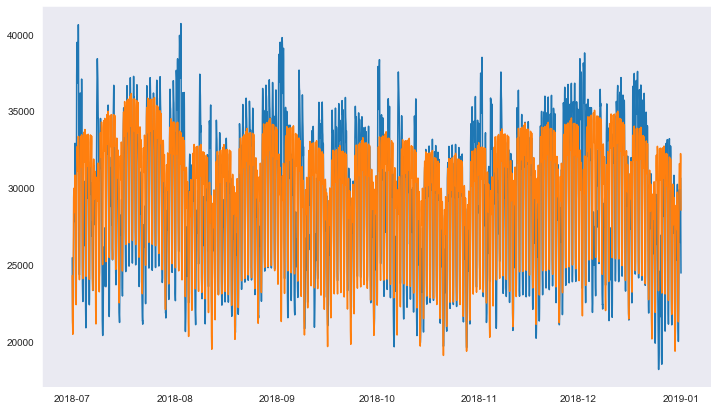

In [53]:
base_model_results = forecast_base_model.iloc[-len(test):]

#inspect the forecast vs the real values
fig = plt.figure(figsize=(12,7))

plt.plot(test['ds'], test['y'])
plt.plot(base_model_results['ds'], base_model_results['yhat'])

#fig1 = base_model.plot(forecast_base_model, uncertainty=False)